# Second try
With no oversampling, but now with bayesian optimization

In [2]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [3]:
# fetch dataset 
rt_iot2022 = fetch_ucirepo(id=942) 
  
# data (as pandas dataframes) divided in input and output 
Input = rt_iot2022.data.features 
Output = rt_iot2022.data.targets 
  
# metadata 
print(rt_iot2022.metadata) 
  
# variable information 
print(rt_iot2022.variables) 

{'uci_id': 942, 'name': 'RT-IoT2022 ', 'repository_url': 'https://archive.ics.uci.edu/dataset/942/rt-iot2022', 'data_url': 'https://archive.ics.uci.edu/static/public/942/data.csv', 'abstract': 'The RT-IoT2022, a proprietary dataset derived from a real-time IoT infrastructure, is introduced as a comprehensive resource integrating a diverse range of IoT devices and sophisticated network attack methodologies. This dataset encompasses both normal and adversarial network behaviours, providing a general representation of real-world scenarios.\nIncorporating data from IoT devices such as ThingSpeak-LED, Wipro-Bulb, and MQTT-Temp, as well as simulated attack scenarios involving Brute-Force SSH attacks, DDoS attacks using Hping and Slowloris, and Nmap patterns, RT-IoT2022 offers a detailed perspective on the complex nature of network traffic. The bidirectional attributes of network traffic are meticulously captured using the Zeek network monitoring tool and the Flowmeter plugin. Researchers can

# Transform data

For this model only the attacks "DOS_SYN_Hping" and "DDOS_Slowloris" are relevant. the information was reshaped so all other categories where changed for "not compromised" ("Thing_Speak" and "Wipro_bulb") or Compromised on all the others

In [4]:

mapping = {
    "DOS_SYN_Hping": "DOS_SYN_Hping",
    "DDOS_Slowloris": "DDOS_Slowloris",
    "Thing_Speak": "Not Compromised",
    "Wipro_bulb": "Not Compromised",
}

# create a new aggregated column
def aggregate_label(lbl):
    if lbl in mapping:
        return mapping[lbl]
    else:
        return "Other Compromise"

Output["Attack_type_agg"] = Output["Attack_type"].apply(aggregate_label)

# (Optionally) replace the original column
# data["Attack_type"] = data["Attack_type_agg"]
# data = data.drop(columns=["Attack_type_agg"])  # if you replaced original differently

# show new composition
print(Output["Attack_type_agg"].value_counts())

# If you want to keep only rows with these four aggregated classes (they are the only ones now),
# this is redundant because aggregation maps everything to one of the four, but:
data_reduced = Output.copy()  # or data_reduced = data[data['Attack_type_agg'].isin([...])]
print("\nReduced shape:", data_reduced.shape)

lout = ['Attack_type_agg']
Y = data_reduced[lout].to_numpy().reshape(-1)


Attack_type_agg
DOS_SYN_Hping       94659
Other Compromise    19563
Not Compromised      8361
DDOS_Slowloris        534
Name: count, dtype: int64

Reduced shape: (123117, 2)


C:\Users\gabri\AppData\Local\Temp\ipykernel_66504\1745957727.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Output["Attack_type_agg"] = Output["Attack_type"].apply(aggregate_label)


# List of relevant features

8 core features were chosen to capture the most distinctive statistical patterns of the three target classes: Normal, DDoS-SYN, and DDoS-Slowloris. These include flow duration, packet rate, SYN flag count, payload throughput, header size, active and idle times, and the down-to-up ratio. Together, they describe complementary aspects of network behaviour: connection length and activity timing (for Slowloris), transport-layer aggressiveness (for SYN floods), and overall balance and periodicity (for normal IoT traffic). This approach ensures that the model remains interpretable and lightweight, allowing direct attribution of Logistic Regression coefficients to specific network phenomena while maintaining compatibility with real-time, resource-constrained IoT environments.

| Feature                    | Normal              | DDoS-SYN (DOS_SYN_Hping) | DDoS-Slowloris         |
| -------------------------- | ------------------- | ------------------------ | ---------------------- |
| `flow_duration`            | Short / periodic    | Short bursts             | Very long              |
| `flow_SYN_flag_count`      | Low (1 per session) | Very high                | Moderate               |
| `fwd_pkts_per_sec`         | Steady              | Very high                | Very low               |
| `payload_bytes_per_second` | Moderate            | High                     | Very low               |
| `fwd_header_size_max`      | Regular             | Small, fixed             | Small, irregular       |
| `active.avg`               | Regular pattern     | Short bursts             | Long periods           |
| `idle.avg`                 | Moderate            | ~0                       | High                   |
| `down_up_ratio`            | Balanced            | High asymmetry           | Balanced / slight skew |


In [5]:

#rlevant inputs to detect syn flood attack
lin = ['flow_SYN_flag_count', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'payload_bytes_per_second', 'fwd_header_size_max','active.avg', 'idle.avg','down_up_ratio'  ]

X = Input[lin]


In [6]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

The data is divided into 60/20/20 (train/val/test), stratified; with the objective to  keep test untouched for the bayesian optimization.

In [7]:


# First split: 60% train, 40% temp (val+test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)

# Second split: split temp into 50/50 (20% val, 20% test)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)


In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(73870, 8)
(24623, 8)
(24624, 8)


# Training

In [9]:
# define the model
model = LogisticRegression(penalty=None, class_weight='balanced', max_iter=500)
# train the model
model.fit(X_train, Y_train)
# create the predictions
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
# build the confusion matrices
confusion_matrix_train = confusion_matrix(Y_train, Y_train_pred)
confusion_matrix_test = confusion_matrix(Y_test, Y_test_pred)
# calculate accuracies
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)
# display the results
print('Training Confusion Matrix')
print(confusion_matrix_train)
print()
print(f'Training accuracy = {train_accuracy}')
print()
print('Testing Confusion Matrix')
print(confusion_matrix_test)
print()
print(f'Testing accuracy = {test_accuracy}')

Training Confusion Matrix
[[  307     0     3    10]
 [    0 56795     0     0]
 [   29    12  4765   211]
 [  677    18  1488  9555]]

Training accuracy = 0.9668607012318938

Testing Confusion Matrix
[[  101     0     3     3]
 [    0 18932     0     0]
 [   14     4  1576    78]
 [  216    11   495  3191]]

Testing accuracy = 0.9665367121507472


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# Compute per class
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_test_pred, digits=4))

                  precision    recall  f1-score   support

  DDOS_Slowloris     0.3051    0.9439    0.4612       107
   DOS_SYN_Hping     0.9992    1.0000    0.9996     18932
 Not Compromised     0.7599    0.9426    0.8414      1672
Other Compromise     0.9752    0.8155    0.8882      3913

        accuracy                         0.9665     24624
       macro avg     0.7599    0.9255    0.7976     24624
    weighted avg     0.9761    0.9665    0.9688     24624



# Regularization

Note that the new penalisation means that $\beta$ should be closer to zero (this is what we mean by 'a simpler model').

For later stages these hyperparameters will be optimized with Bayesian optimization
<ul>
    <li>Regularisation strength "C"
    <li>Penalty (categorical: L2 vs. L1 vs. elastic-net)
    <li>Class-weight scaling (continuous multiplier on “balanced”: e.g. 0.5–2.0)
</ul>

Best test accuracy was achieved with C = 0.00959803015075377, giving an accuracy of 0.9469601592007473.
Without regularisation, we achieved an accuracy of 0.9665367121507472.



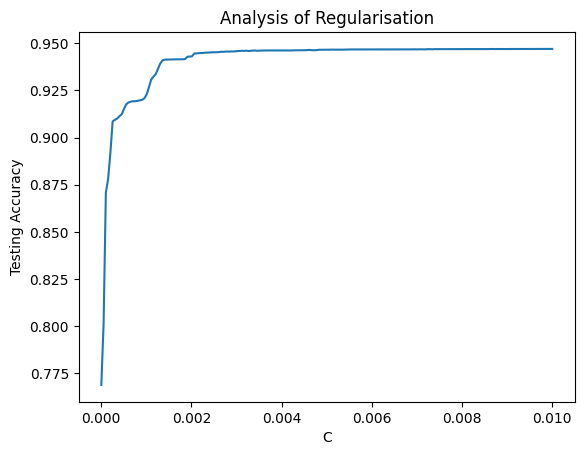

In [13]:

C_space = np.linspace(1e-6, 1e-2, 200)
accuracies = []

for C in C_space:
  model = LogisticRegression(penalty = 'l2', C = C)
  model.fit(X_train, Y_train)
  Y_val_pred = model.predict(X_val)
  accuracies.append(accuracy_score(Y_val, Y_val_pred))

plt.plot(C_space, accuracies)
plt.xlabel('C')
plt.ylabel('Testing Accuracy')
plt.title('Analysis of Regularisation')

best_model = np.argmax(accuracies)
best_accuracy = accuracies[best_model]
best_C = C_space[best_model]

print(f'Best test accuracy was achieved with C = {best_C}, giving an accuracy of {best_accuracy}.') 
print(f'Without regularisation, we achieved an accuracy of {test_accuracy}.')
print()

In [14]:
# Compute per class
print(classification_report(Y_test, Y_test_pred, digits=4))

                  precision    recall  f1-score   support

  DDOS_Slowloris     0.3051    0.9439    0.4612       107
   DOS_SYN_Hping     0.9992    1.0000    0.9996     18932
 Not Compromised     0.7599    0.9426    0.8414      1672
Other Compromise     0.9752    0.8155    0.8882      3913

        accuracy                         0.9665     24624
       macro avg     0.7599    0.9255    0.7976     24624
    weighted avg     0.9761    0.9665    0.9688     24624



# After regularization metrics


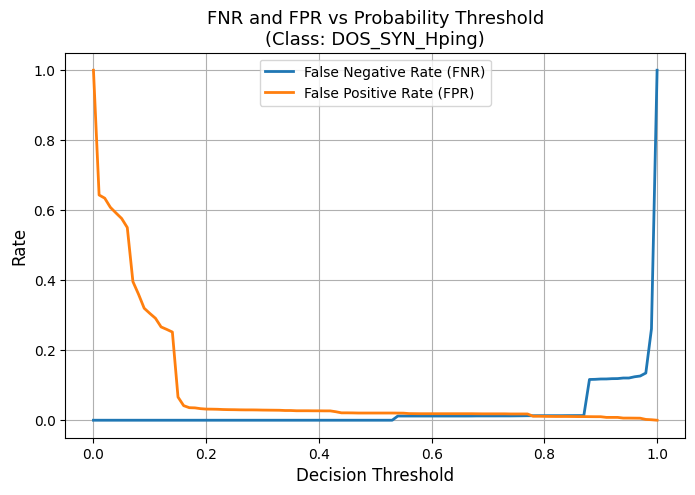

In [15]:

# --- Choose the class you want to analyze ---
target_label = "DOS_SYN_Hping"   # change as needed

# --- Get class index directly from model ---
classes = model.classes_
if target_label not in classes:
    raise ValueError(f"{target_label} not found in model classes: {classes}")
pos_idx = np.where(classes == target_label)[0][0]

# --- Get predicted probabilities for that class ---
y_proba = model.predict_proba(X_test)[:, pos_idx]

# --- Convert true labels to binary (1 = target, 0 = others) ---
y_true_bin = (Y_test == target_label).astype(int)

# --- Sweep thresholds and compute FNR/FPR ---
thresholds = np.linspace(0, 1, 101)
fnr_list, fpr_list = [], []

for t in thresholds:
    y_pred_bin = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1]).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fnr_list.append(fnr)
    fpr_list.append(fpr)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(thresholds, fnr_list, label="False Negative Rate (FNR)", linewidth=2)
plt.plot(thresholds, fpr_list, label="False Positive Rate (FPR)", linewidth=2)
plt.xlabel("Decision Threshold", fontsize=12)
plt.ylabel("Rate", fontsize=12)
plt.title(f"FNR and FPR vs Probability Threshold\n(Class: {target_label})", fontsize=13)
plt.legend()
plt.grid(True)
plt.show()


# Bayesian Optimization 
Bayesian Optimization loop that maximizes macro-F1 on the validation set to tune C for Logistic Regression. It builds a fresh Pipeline (StandardScaler + Multinomial LR) each trial

| Step                   | Purpose                                                                                                |
| ---------------------- | ------------------------------------------------------------------------------------------------------ |
| `penalty_flag`         | Encodes `'l1'` and `'l2'` as numeric values (0–1) for the optimizer                                    |
| `solver` switch        | `saga` supports both L1 and L2; `lbfgs` supports L2 only                                               |
| `objective()`          | Fits the model with the current `(C, penalty)` and returns macro-F1 on validation set                  |
| `BayesianOptimization` | Builds a probabilistic model of F1 across these parameters to pick the next most promising combination |
| `optimizer.max`        | Returns the best found parameters and score                                                            |
| Retraining step        | Trains one final model on all train+val data with best parameters and evaluates on test                |


In [16]:
from bayes_opt import BayesianOptimization
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [22]:
# Create pipeline: scaling + logistic regression

def make_pipe(C_val: float, penalty_type: str) -> Pipeline:
    solver = "saga" if penalty_type == "l1" else "lbfgs"
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty=penalty_type,
            solver=solver,
            multi_class="multinomial",
            class_weight="balanced",
            max_iter=3000,
            n_jobs=-1,
            C= best_C
        ))
    ])

In [25]:

# Bayesian Optimization objective (maximize macro-F1 on VAL) 
def objective(log10_C, penalty_flag):
    # map numeric flag to string penalty
    penalty_type = "l1" if penalty_flag < 0.5 else "l2"
    C = 10.0 ** log10_C
    try:
        pipe = make_pipe(C, penalty_type)
        pipe.fit(X_train, Y_train)
        yv = pipe.predict(X_val)
        f1 = f1_score(Y_val, yv, average="macro")
    except Exception:
        f1 = 0  # in case solver/penalty combo fails
    return f1

# Search bounds for C in [1e-6, 1e+2]
pbounds = {
    "log10_C": (-6, 2),   # 1e-6 to 1e2
    "penalty_flag": (0, 1)  # 0 → L1, 1 → L2
}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

print("\nRunning Bayesian Optimization for C and penalty...")
optimizer.maximize(init_points=5, n_iter=30)




Running Bayesian Optimization for C and penalty...
|   iter    |  target   |  log10_C  | penalt... |
-------------------------------------------------


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 1         | 0.5859864 | -3.003679 | 0.9507143 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 2         | 0.5859864 | -0.144048 | 0.5986584 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 3         | 0.5736523 | -4.751850 | 0.1559945 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 4         | 0.5859864 | -5.535331 | 0.8661761 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 5         | 0.5859864 | -1.191079 | 0.7080725 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 6         | 0.5859864 | -0.149903 | 0.6666855 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 7         | 0.5737618 | -2.201081 | 0.1492356 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 8         | 0.5737618 | -0.755187 | 0.0897164 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 9         | 0.5859864 | -0.768788 | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 10        | 0.5859864 | 0.4597311 | 0.6108967 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 11        | 0.5859864 | -3.639725 | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 12        | 0.5859864 | -1.308158 | 0.9808633 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 13        | 0.5736523 | 1.1392784 | 0.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 14        | 0.5737618 | -2.798273 | 0.2034484 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 15        | 0.5737618 | -6.0      | 0.3583181 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 16        | 0.5859864 | -3.019308 | 0.7212937 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 17        | 0.5736523 | -4.358974 | 0.0952688 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 18        | 0.5859864 | -4.992034 | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 19        | 0.5859864 | 2.0       | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 20        | 0.5859864 | 1.1704924 | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 21        | 0.5859864 | -2.413707 | 0.5601949 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 22        | 0.5736523 | -3.288193 | 0.1019048 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 23        | 0.5859864 | -2.196093 | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 24        | 0.5859864 | 0.4384136 | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 25        | 0.5859864 | -0.151469 | 0.6069303 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 26        | 0.5859864 | -4.268851 | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 27        | 0.5737618 | 2.0       | 0.3839602 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 28        | 0.5859864 | -2.590200 | 0.8886082 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 29        | 0.5859864 | -1.767459 | 0.7375765 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 30        | 0.5859864 | -6.0      | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 31        | 0.5736523 | 0.2284095 | 0.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 32        | 0.5859864 | 1.6002568 | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 33        | 0.5859864 | 0.7928498 | 0.8318709 |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 34        | 0.5859864 | -5.370102 | 1.0       |


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


| 35        | 0.5859864 | -4.621663 | 1.0       |


In [26]:
# Retrieve best parameters
best_log10_C = optimizer.max["params"]["log10_C"]
best_penalty_flag = optimizer.max["params"]["penalty_flag"]
best_penalty = "l1" if best_penalty_flag < 0.5 else "l2"
best_C = 10.0 ** best_log10_C
best_val_f1 = optimizer.max["target"]

print(f"\nBest parameters found:")
print(f"  Penalty: {best_penalty}")
print(f"  C = {best_C:.6g} (log10_C={best_log10_C:.3f})")
print(f"  Validation macro-F1 = {best_val_f1:.4f}")


Best parameters found:
  Penalty: l2
  C = 0.000991564 (log10_C=-3.004)
  Validation macro-F1 = 0.5860


In [27]:
# Retrain on TRAIN+VAL using best hyperparameters
X_trv = np.vstack([X_train, X_val])
Y_trv = np.concatenate([Y_train, Y_val])

final_model = make_pipe(best_C, best_penalty)
final_model.fit(X_trv, Y_trv)

Y_test_pred = final_model.predict(X_test)
print("\n=== TEST RESULTS ===")
print(classification_report(Y_test, Y_test_pred, digits=4))
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(Y_test, Y_test_pred))

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== TEST RESULTS ===
                  precision    recall  f1-score   support

  DDOS_Slowloris     0.1052    0.9626    0.1897       107
   DOS_SYN_Hping     0.9994    0.9862    0.9927     18932
 Not Compromised     0.5070    0.6453    0.5679      1672
Other Compromise     0.9739    0.7059    0.8185      3913

        accuracy                         0.9184     24624
       macro avg     0.6464    0.8250    0.6422     24624
    weighted avg     0.9580    0.9184    0.9327     24624

Confusion matrix (rows=true, cols=pred):
 [[  103     0     3     1]
 [    0 18670   262     0]
 [  513     7  1079    73]
 [  363     4   784  2762]]
